## VCB

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0402 - val_loss: 0.0040
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 8.3811e-04 - val_loss: 0.0013
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 6.4304e-04 - val_loss: 0.0012
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 6.0668e-04 - val_loss: 0.0011
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 5.7843e-04 - val_loss: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 5.5564e-04 - val_loss: 9.6504e-04
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 5.1343e-04 - val_loss: 8.0131e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 4.5361e-04 - val_loss: 7.9755e-04
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 4.1953e-04 - val_loss: 7.5040e-04
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 4.0056e-04 - val_loss: 6.9117e-04
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.8560e-04 - val_loss

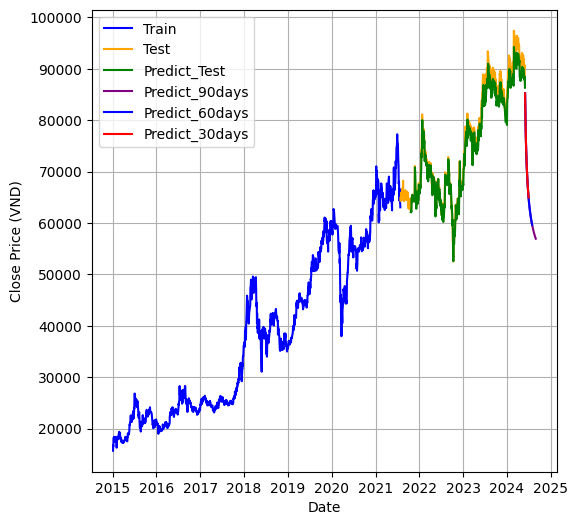

In [14]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')
plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')

# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [15]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)

Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  85215.679688
2024-06-02  83540.039062
2024-06-03  82028.304688
2024-06-04  80673.031250
2024-06-05  79395.148438
...                  ...
2024-08-25  57220.164062
2024-08-26  57147.816406
2024-08-27  57076.535156
2024-08-28  57006.308594
2024-08-29  56937.101562

[90 rows x 1 columns]


In [16]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1847.9405739579774
MAPE: 1.8352117548188953 %
MAE: 1463.1619329244543


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.0121 - val_loss: 0.0028
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 9.9547e-04 - val_loss: 0.0013
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 8.9595e-04 - val_loss: 0.0012
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 8.1756e-04 - val_loss: 0.0011
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 7.5887e-04 - val_loss: 0.0011
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 7.0775e-04 - val_loss: 0.0011
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 6.6022e-04 - val_loss: 0.0010
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 6.1679e-04 - val_loss: 9.3839e-04
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 5.7880e-04 - val_loss: 8.5673e-04
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 5.4673e-04 - val_loss: 7.9284e-04
Epo

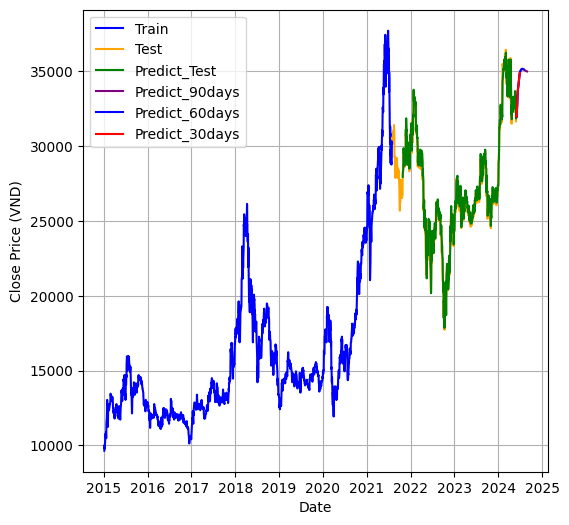

In [6]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')
plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [7]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast CTG stock prices for the next 90 days:")
print(future_df)

Forecast CTG stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  31996.005859
2024-06-02  31961.644531
2024-06-03  31954.496094
2024-06-04  32034.041016
2024-06-05  32175.906250
...                  ...
2024-08-25  35009.347656
2024-08-26  35005.675781
2024-08-27  35002.054688
2024-08-28  34998.550781
2024-08-29  34995.207031

[90 rows x 1 columns]


In [8]:
# Tính RMSE, MAPE, và MAE trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 593.1187354299664
MAPE: 1.6778067183450218 %
MAE: 442.96452227290365


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (70/30)
train_size = int(len(y_norm) * 0.7)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(50))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra
Y_pred_test = model.predict(X_test)
Y_pred_test = scaler.inverse_transform(Y_pred_test.reshape(-1,1))  # Reshape to 2D before inverse transform
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:]
future_predictions = []
for i in range(90):  
    next_pred = model.predict(last_sequence.reshape(1, n_lookback, 1))
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.0219
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 8.9594e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 8.6278e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 7.6608e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 6.9948e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 6.3101e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 5.7897e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 5.4544e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 5.1630e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 4.9325e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 4.7477e-04
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 4.5910e-04
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 4.4544e-04
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 4.3326e-04
Epoc

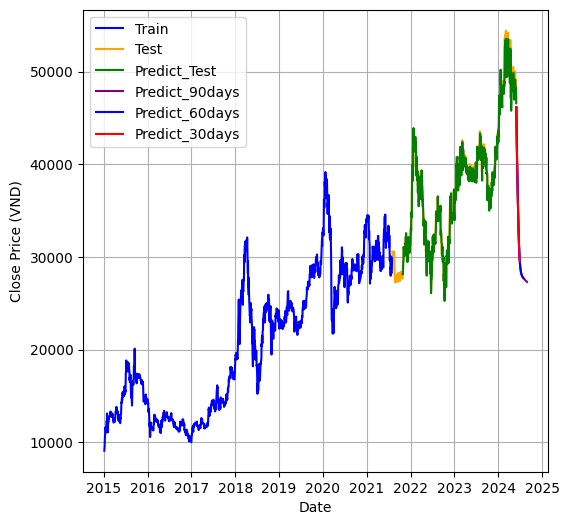

In [10]:
# Visualization
plt.figure(figsize=(6, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('BID Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [11]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast BID stock prices for the next 90 days:")
print(future_df)


Forecast BID stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  46145.460938
2024-06-02  45038.312500
2024-06-03  44009.238281
2024-06-04  43065.574219
2024-06-05  42175.738281
...                  ...
2024-08-25  27350.794922
2024-08-26  27337.617188
2024-08-27  27324.511719
2024-08-28  27311.480469
2024-08-29  27298.535156

[90 rows x 1 columns]


In [12]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 954.9387142857837
MAPE: 1.839238292414849 %
MAE: 706.56270623059
